In [2]:
from astropy.io import fits
from astropy.wcs import WCS
import png
import numpy as np
from utils import zscale
import matplotlib.pyplot as plt
import math
import scipy
from os import listdir
from os.path import isfile, join
import cupy as cp

DATA_PATH = 'SatSimPNG'
TOTAL_VELOCITY_VECTORS = 100
IMAGES_TO_STACK = [DATA_PATH + '/' + f for f in listdir(DATA_PATH) if isfile(join(DATA_PATH, f))]
NUM_FRAMES = len(IMAGES_TO_STACK)
DIMENSIONS = (512, 512)

In [3]:
#Convert all images to greyscale
from PIL import Image

for path in IMAGES_TO_STACK:
    img = Image.open(path).convert('L')
    img.save(path[:-3]+'png')

Images before preprocessing

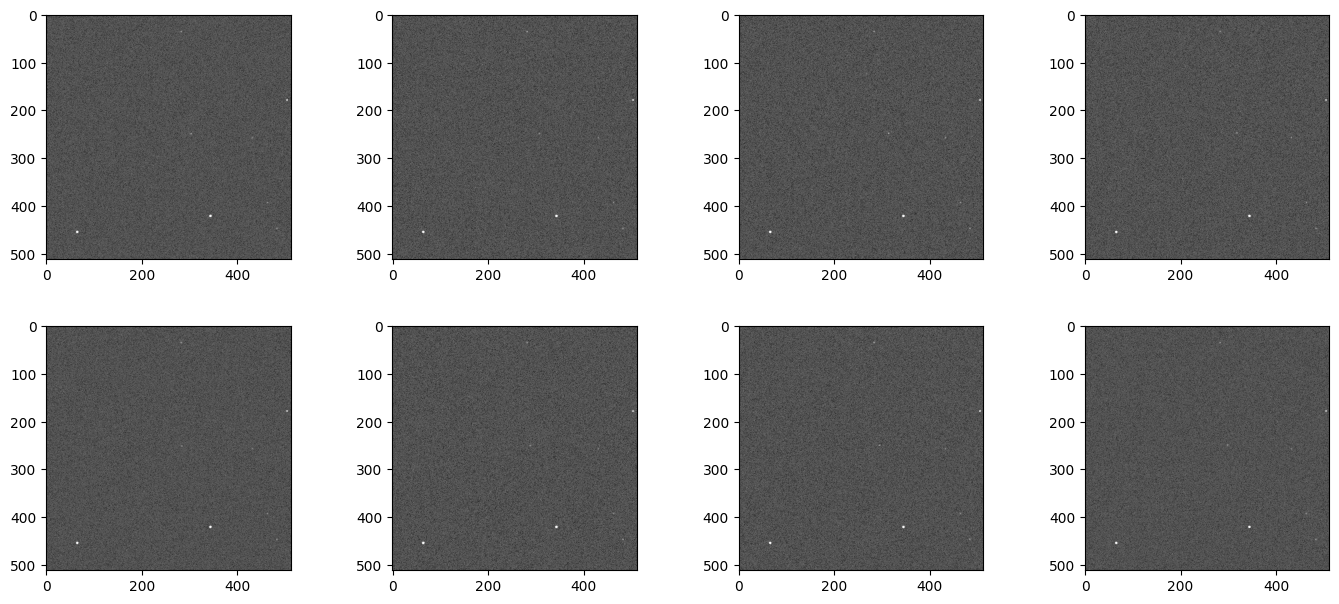

In [18]:
plt.rcParams["figure.figsize"] = [14.00, 15.00]
plt.rcParams["figure.autolayout"] = True

total_images = len(IMAGES_TO_STACK)
row_counter = 1
column_counter = 1
for file in IMAGES_TO_STACK:
    plt.subplot(row_counter, 4, column_counter)
    plt.imshow(np.vstack(list(map(np.uint16, png.Reader(file).asDirect()[2]))), cmap="Greys_r")
    column_counter += 1
    if column_counter > 4:
        column_counter = 1
        row_counter += 1

Star Field Correction.
Finds the background, and removes stars based on the first frame in the folder. Then applies the star removal to all other frames.

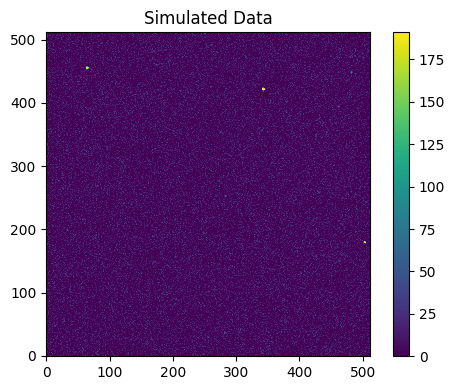

In [22]:
import numpy as np
from photutils.datasets import make_test_psf_data, make_noise_image
from photutils.psf import IntegratedGaussianPRF
import matplotlib.pyplot as plt
import png
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground

first_frame = np.vstack(list(map(np.uint16, png.Reader(IMAGES_TO_STACK[0]).asDirect()[2])))

#Code to find the background
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(first_frame, (50, 50), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
new_img = (first_frame - bkg.background).clip(min=0)


plt.rcParams["figure.figsize"] = [5, 4]
plt.imshow(new_img, origin='lower',
           interpolation='nearest')
plt.title('Simulated Data')
plt.colorbar()

 id  x_fit    y_fit    flux_fit
--- -------- -------- ---------
  1 281.9368  36.1505  786.9837
  2 503.2622 179.2055 1696.2699
  3 430.9543 257.9923  515.8106
  4 462.2547 393.3953  571.2195
  5 343.2024 421.4798 2854.5208
  6 343.1868 421.4794 2855.2427
  7 343.1935 421.4586 2855.4585
  8 482.1434 447.4195  723.3852
  9  64.8872 454.8240 2796.8844
 10  64.8866 454.8361 2795.6493
 11  64.8896 454.8223 2796.9022
(512, 512)


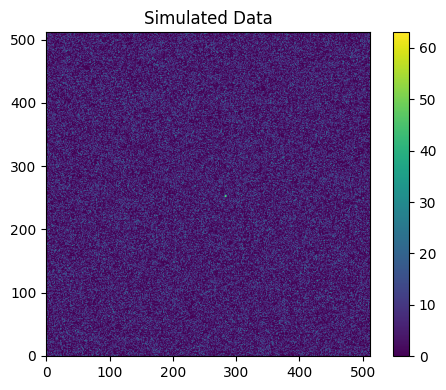

In [29]:
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry

#Code for PSF and star removal
psf_model = IntegratedGaussianPRF(flux=1, sigma=2.7 / 2.35)
fit_shape = (11, 11)
finder = DAOStarFinder(53.0, 3.0)
psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,
                        aperture_radius=4)
phot = psfphot(new_img)

#To look at removed stars
phot['x_fit'].info.format = '.4f' 
phot['y_fit'].info.format = '.4f'
phot['flux_fit'].info.format = '.4f'
print(phot[('id', 'x_fit', 'y_fit', 'flux_fit')]) 

resid = psfphot.make_residual_image(new_img, (9, 9))
print(resid.shape)
resid = resid.clip(min = 0)

plt.rcParams["figure.figsize"] = [5, 4]
plt.imshow(resid, origin='lower')
plt.title('Simulated Data')
plt.colorbar()

In [32]:
processed_images = []
for file in IMAGES_TO_STACK:
    unprocessed_img = np.vstack(list(map(np.uint16, png.Reader(file).asDirect()[2])))
    no_bkg = (unprocessed_img - bkg.background)
    processed_images.append(psfphot.make_residual_image(no_bkg, (9, 9)).clip(min=0))

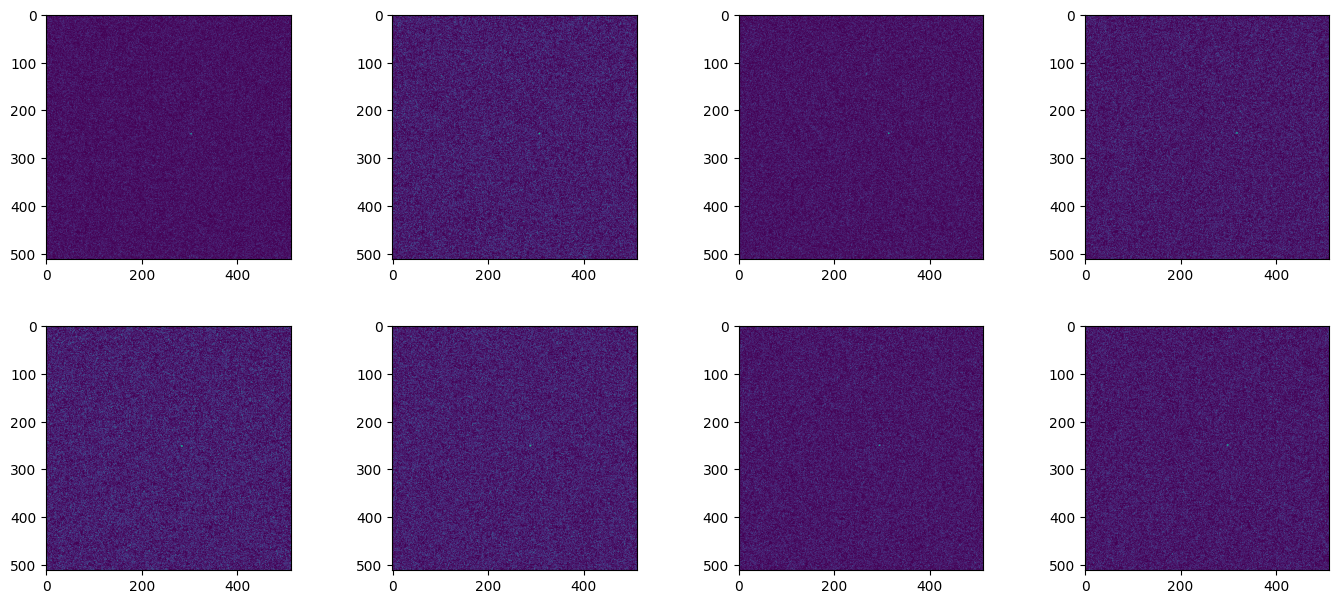

In [33]:
plt.rcParams["figure.figsize"] = [14.00, 15.00]
plt.rcParams["figure.autolayout"] = True

total_images = len(IMAGES_TO_STACK)
row_counter = 1
column_counter = 1
for image in processed_images:
    plt.subplot(row_counter, 4, column_counter)
    plt.imshow(image)
    column_counter += 1
    if column_counter > 4:
        column_counter = 1
        row_counter += 1

In [ ]:
#Convert to cupy arrays
processed_images_cupy = []
for image in processed_images:
    


Creates the predictive velocity vectors in which shifts will be applied

In [37]:
#For rounding
a = int(math.sqrt(TOTAL_VELOCITY_VECTORS)) 
b = math.floor(a/2)
if a % 2 == 0:
    a += 1

velocities = cp.zeros(shape = (a * a, 2))
vel_to_idx = {}

idx = 0
for i in range(-b, b+1):
    for j in range(-b, b+1):
        vel_to_idx[(i,j)] = idx
        velocities[idx] = cp.asarray([i,j])
        idx += 1

print('A total of ' + str(a * a) + ' velocities will be tested.')
print('Range of velocity for both x and y direction: ' + str([-b, b]))

A total of 121 velocities will be tested.
Range of velocity for both x and y direction: [-5, 5]


In [40]:
from cupyx.scipy import ndimage

def stack(frames: list, velocity_vector):
    '''
    Inputs:
        file_path is a list of strings refering to the images that are to be stacked
        
        velocity_vector is a 2D numpy array where the first entry is the x velocity 
        and the second is the y velocity. (i.e [-1, 2]). As of now, the units of vel
        are pixel/frame.

    Output:
        a stacked image of all frames.
    '''
    final_dimensions = DIMENSIONS
    stacked_image = cp.zeros(shape=final_dimensions)
    iter = 0
    init_x_vel = velocity_vector[0]
    init_y_vel = velocity_vector[1]

    for image in frames:
        img_shifted = ndimage.shift(image, velocity_vector, mode='constant')
        if iter != 0:
            stacked_image += img_shifted
        iter += 1
        velocity_vector = [init_y_vel * iter, init_x_vel * iter]
    return stacked_image

Example usage of the stack function with velocity vector [0, -3]

In [41]:
plt.rcParams["figure.figsize"] = [7.5, 7.5]
plt.rcParams["figure.autolayout"] = False
final = stack(processed_images, [-5., 1])
plt.imshow((cp.ndarray.get(final)), cmap="Greys_r")

TypeError: Argument 'a' has incorrect type (expected cupy._core.core._ndarray_base, got numpy.ndarray)

In [11]:
def build_data_cube(file_paths, all_vectors):
    '''
    Creates a dictionary of stacked frames for each velocity vector

    Inputs: file_path is a list of strings refering to the images that are to be stacked

    all_vectors is a list of 2D numpy array where the first entry is the x velocity 
        and the second is the y velocity. (i.e [-1, 2]). As of now, the units of vel
        are pixel/frame.
    
    Output: a dictionary of the final stacked frames where the velocity vector in tuple 
        form is the key for retreiving a stacked image.
    '''
    data_cube = []
    for velocity in all_vectors:
        stacked_image = stack(file_paths=file_paths, velocity_vector=velocity)
        data_cube.append(stacked_image)
    return data_cube

data_cube = build_data_cube(IMAGES_TO_STACK, velocities)

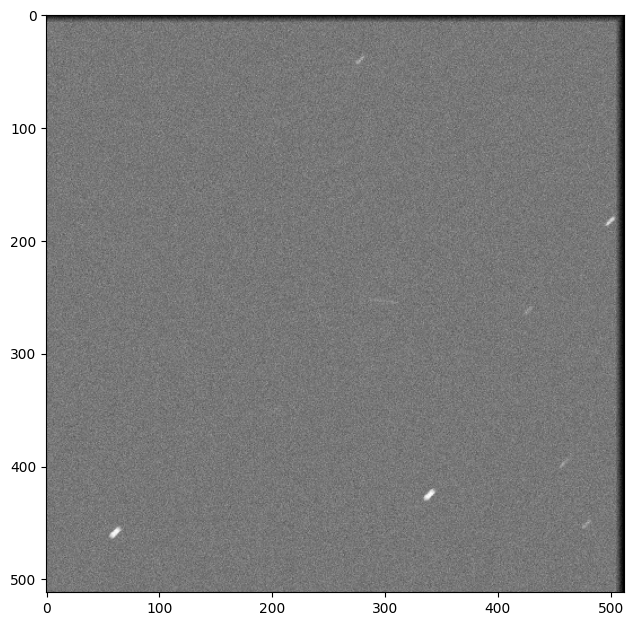

In [16]:
plt.imshow((cp.ndarray.get(data_cube[vel_to_idx[(-1,1)]])), cmap="Greys_r")